# Content

- Start: generate ensemble [...]
- [Compare different ways to extract uncertainties](#compare_diff_extraction)
    - [1) visual comparison of solutions](#visual_comparison)
    - [2) is there a hidden transformation](#hidden_transformation): This section contains the correlation plots  
        -[summary](#hidden_summary)
- [Let's just give it a try -- what is the difference?](#applying)
    - [real Dy dataset](#applying_a)
    - [synthetic dataset](#applying_b)
    - [summary](#applying_summary)
   

# Getting started

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
from pathlib import Path

In [26]:
# Load the submodule, so that we are sure we use the same version
import sys
sys.path.insert(0, "ompy")
import ompy as om

In [27]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('axes', labelsize="large")
rc('errorbar', capsize=2.) # Set error bar style

In [28]:
om.__full_version__

'0.9.1.dev0+0713f82'

In [29]:
# For reproducability we seed the random generator. 
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [30]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

## Loading and example raw spectra

The $^{164}\mathrm{Dy}$ data used below has been gathered from following experiment: Nyhus, H. T. *et al.* (2010). DOI: [10.1103/physrevc.81.024325](https://doi.org/10.1103/PhysRevC.81.024325)
and is reanalyzed in Renstrøm, T. *et al.* (2018). DOI: [10.1103/physrevc.98.054310](https://doi.org/10.1103/PhysRevC.98.054310)

In [31]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.example_raw('Dy164')
# To use you own data, uncomment/adapt the line below instead
# raw = om.Matrix(path="/path/to/matrix.ending")

# Plot the entire matrix
raw_org = raw.copy() # workaround due to execution order in jupyter notebook
                     # (calculations are performed before plotting, but we make a cut to raw further down)
raw_org.plot();


# Note: We use the semi-colon `;` at the end of the line to silence the output
# in jupyter notebook. This is not necessary, but otherwise you get something like 
# this below printed every time:
#(<matplotlib.collections.QuadMesh at 0x7fafbc422eb8>,
# <matplotlib.axes._subplots.AxesSubplot at 0x7fafc0944a20>,
# <Figure size 640x480 with 2 Axes>)

<IPython.core.display.Javascript object>

## Matrix manipulation

The core of the Oslo method involves working with two dimensional spectra. Starting with a raw matrix of $E_x$-$E_\gamma$ coincidences, you typically want to unfold the counts
along the gamma-energy axis and then apply the first-generation method to obtain the matrix of first-generation, or primary, gamma rays from the decaying nucleus.

The two most important utility classes in the package are `Matrix()` and `Vector()`. They are used to store matrices (2D) or vectors (1D) of numbers, typically spectra of counts, along with energy calibration information. 

As these underpin the entire package, they contain many useful functions to make life easier. Loading and saving to several formats, plotting, projections, rebinning and cutting, to mention a few. See the documentation for an exhaustive list.

Their basic structure is:

In [32]:
# mat = ompy.Matrix()
mat = raw
mat.values  # A 2D numpy array
mat.Ex      # Array of mid-bin energy values for axis 0 (i.e. the row axis, or y axis)
mat.Eg      # Array of mid-bin energy values for axis 1 (i.e. the column axis, or x axis)

print("The first gamma-ray energies:\n", mat.Eg[0:10])

The first gamma-ray energies:
 [  0.     19.364  38.728  58.092  77.456  96.82  116.184 135.548 154.912
 174.276]


In [33]:
# We can also create a vector, which is useful to store the NLD and gSF.
values = np.arange(11)
E = np.linspace(0, 10, num=11)

fig, ax = plt.subplots(figsize=(2,2), constrained_layout=True)
vec = om.Vector(values=values, E=E)
vec.values  # A 1D numpy array
vec.E       # Array of lower-bin-edge energy values for the single axis
vec.plot(ax=ax);

<IPython.core.display.Javascript object>

In [34]:
# Cut away counts above the diagonal 
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.
# Note that the raw matrix we read in above has been cut already, so the difference here is not so large.
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, 8400)
raw.plot();

<IPython.core.display.Javascript object>

Note that `Matrix`, `Vector` and several other classes contain mutable objects. If you work on them, you might want to create a *deepcopy*. For `Matrix`, `Vector` this can be archived by the convince method `X.copy`, otherwise use `copy.deepcopy`.

In [35]:
# The "right" way if you don't want to change the original matrix
raw_big_cut = raw.copy()
raw_big_cut.cut('Ex', 0, 4000)
print(raw.Ex.max(), raw_big_cut.Ex.max())

8300.0 3980.0


In [36]:
# The "wrong" way if you don't want to change the original matrix
raw_big_cut2 = raw_big_cut
raw_big_cut2.cut('Ex', 0, 2000)
print(raw_big_cut.Ex.max(), raw_big_cut2.Ex.max())
# oups!: suddenly also `raw_big_cut` was cut, not only raw_big_cut2

1940.0 1940.0


In [37]:
# Plot projections
raw.plot_projection('Ex', Emin=1800, Emax=2600, kind="step");

<IPython.core.display.Javascript object>

Note that you can IPython's has tools to quickly access information on a function, namely the `?` character to explore documentation, the `??` characters to explore source code, and the `Tab key` (or `double-tab`) for auto-completion. Try it out uncommenting the function below.

In [38]:
## Uncomment these lines to query a function
# ?raw.plot_projection

## Unfolding

### Get a response matrix
Eventhough this experiment was performed with CACTUS, we will now give an example *as if* the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately.

In [39]:
logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrices are stored
folderpath = "ompy/OCL_response_functions/oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
R_ompy_view.plot(title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");



2020-03-31 09:03:56,924 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-03-31 09:04:08,054 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.


<IPython.core.display.Javascript object>

### Perform the unfolding

In [40]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=2)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)
unfolded.plot();

<IPython.core.display.Javascript object>

### Generate the first generation matrix

In [41]:
firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

<IPython.core.display.Javascript object>

## Propagating statistical uncertainties

In order to propagate the statistical uncertainties from the raw matrix, we use an ensemble based method. We start of my generating en ensemble of *raw-like* matrices. The raw counts are Poisson distributed. If we had counted one another time, we would get slightly different results. 

More precisely, the counts of the matrix containing `prompt+bg` events and the background events `bg` are each Poisson distributed, where we have `raw = (prompt+bg) - bg_ratio * bg`. The ratio `bg_ratio` is determined by the ratio of the time gate lengths taken to obtain the `prompt+bg` and `bg` spectra. If a `bg` spectrum is provided to the `Ensemble` class, it will calculate the raw spectrum according to the equation above. Otherwise, the provided `raw` spectrum itself is assumed to be Poisson distributed.

We take the number of counts $k_i$ in bin $i$ of the raw matrix $R$ as an estimate for the Poisson parameter ("the mean") $λ_i$ . Note that it is an unbiased estimator for $λ_i$, since $E(k) = λ$. To generate a member matrix $R_l$ of the MC ensemble, we replace the counts in each bin $i$ by a random draw from the distribution $\operatorname{Poisson}(k_i)$.

The class Ensemble() provides this feature. Its basic usage is:

In [98]:
logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(200, regenerate=False)

2020-03-31 10:20:10,540 - ompy.ensemble - INFO - Start normalization with 3 cpus


2020-03-31 10:20:10,797 - ompy.ensemble - INFO - Generating 0
2020-03-31 10:20:10,853 - ompy.ensemble - INFO - Generating 1
2020-03-31 10:20:10,901 - ompy.ensemble - INFO - Generating 2
2020-03-31 10:20:10,945 - ompy.ensemble - INFO - Generating 3
2020-03-31 10:20:10,999 - ompy.ensemble - INFO - Generating 4
2020-03-31 10:20:11,026 - ompy.ensemble - INFO - Generating 5
2020-03-31 10:20:11,078 - ompy.ensemble - INFO - Generating 6
2020-03-31 10:20:11,129 - ompy.ensemble - INFO - Generating 7
2020-03-31 10:20:11,182 - ompy.ensemble - INFO - Generating 8
2020-03-31 10:20:11,216 - ompy.ensemble - INFO - Generating 9
2020-03-31 10:20:11,249 - ompy.ensemble - INFO - Generating 10
2020-03-31 10:20:11,277 - ompy.ensemble - INFO - Generating 11
2020-03-31 10:20:11,337 - ompy.ensemble - INFO - Generating 12
2020-03-31 10:20:11,383 - ompy.ensemble - INFO - Generating 13
2020-03-31 10:20:11,437 - ompy.ensemble - INFO - Generating 14
2020-03-31 10:20:11,490 - ompy.ensemble - INFO - Generating 15
20

2020-03-31 10:20:16,603 - ompy.ensemble - INFO - Generating 130
2020-03-31 10:20:16,655 - ompy.ensemble - INFO - Generating 131
2020-03-31 10:20:16,707 - ompy.ensemble - INFO - Generating 132
2020-03-31 10:20:16,753 - ompy.ensemble - INFO - Generating 133
2020-03-31 10:20:16,798 - ompy.ensemble - INFO - Generating 134
2020-03-31 10:20:16,848 - ompy.ensemble - INFO - Generating 135
2020-03-31 10:20:16,886 - ompy.ensemble - INFO - Generating 136
2020-03-31 10:20:16,946 - ompy.ensemble - INFO - Generating 137
2020-03-31 10:20:16,991 - ompy.ensemble - INFO - Generating 138
2020-03-31 10:20:17,026 - ompy.ensemble - INFO - Generating 139
2020-03-31 10:20:17,075 - ompy.ensemble - INFO - Generating 140
2020-03-31 10:20:17,103 - ompy.ensemble - INFO - Generating 141
2020-03-31 10:20:17,135 - ompy.ensemble - INFO - Generating 142
2020-03-31 10:20:17,195 - ompy.ensemble - INFO - Generating 143
2020-03-31 10:20:17,234 - ompy.ensemble - INFO - Generating 144
2020-03-31 10:20:17,284 - ompy.ensemble 

The generated members are saved to disk and can be retrieved. Unfolded members can be retrieved as `ensemble.get_unfolded(i)`, for example. Their standard deviation is `ensemble.std_unfolded` for the unfolded matrices, etc.

## Extract Nuclear level density and gamma strength function

After matrix has been cut, unfolded and firstgen'd, perhaps ensembled, its nuclear level density (nld) and gamma strength function ($\gamma$SF) can be extracted using the `Extractor()` class.  

The method relies on the relation
 \begin{align}
	P(E_x, E_\gamma) \propto NLD(E_x - E_\gamma) \mathcal{T}(E_\gamma),\label{eq:Oslo_method_eq}
\end{align}
where $P(E_x, E_\gamma)$ is the first-generation spectrum normalized to unity for each $E_x$ bin.  
Furthermore, if we assume that the $\gamma$ decay at high $E_x$ is dominated by dipole radiation the transmission coefficient $\mathcal{T}$ is related to the dipole $\gamma$-ray strength function $f(E_\gamma)$ by the relation
\begin{align}
    \mathcal{T}(E_\gamma) = 2\pi E_\gamma^3 f(E_\gamma).\label{eq:gammaSF}
\end{align} 

If you have reasons to assume a different multipole decomposition, you may of course calculate the transmission coefficient $\mathcal{T}$ from the $\gamma$-ray strength function produced here and apply the decomposition you prefer.

For a single matrix, its usage is:  
(well, think about what you want to set in as the std. deviation)

In [99]:
# cutout = primary.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# cutout_std = ensemble.std_firstgen.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# extractor = om.Extractor()
# nld, gsf = extractor.decompose(cutout, std=cutout_std)

When extracting NLD and GSF from an ensemble, a trapezoidal cutout must be performed on each ensemble member. This is achieved by `Action()` which allows for delayed function calls on matrices and vectors. This way we don't cut the raw matrix at `Ex_min`, but this will only happen before the extraction.

<IPython.core.display.Javascript object>


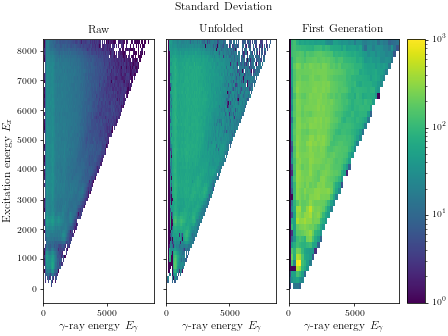

In [100]:
# logger = om.introspection.get_logger('extractor', 'INFO')
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=4000, Ex_max=7000, Eg_min=1000, Eg_max=7000+200, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably 
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace. 
# Note: As always, be careful will mid-bin vs lower bin calibration.
# E_rebinned = ensemble.get_firstgen(0).Ex
# 
E_rebinned = np.arange(100., 8500, 200)
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

Now we can extract the NLD and $\gamma SF$ for $N$ of the samples of the ensemble.

Note: 
The old software extended the decomposition beyond the `Ex=Eg` line by a resolution `dE`. This is now optional and we changed the default to not do this any longer, but rather assume that the rebinning above has been performed with a binsize of approx. the FWHM of the bin with the worst resolution (usually `(Ex_max, Eg_max)`).

In [101]:
extractor.extract_from(ensemble, regenerate=True)

The resulting `nld` and `gsf` are saved to disk and exposed as `extractor.nld` and `extractor.gsf`

In [102]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)
fig, ax = plt.subplots(2,1)
om.normalize_rows(mat.values) 
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1)
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1)

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g")
ax[1].plot(x, x, "r--", label="E_x = E_g")

<IPython.core.display.Javascript object>

### Plotting the results before normalization

In [103]:
extractor.plot(plot_mean=False)

<IPython.core.display.Javascript object>

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa88f7ee438>,
       dtype=object))

Or maybe you are more used to displaying the results with std. deviations?

**Note**: This may be erroneous, as the nld and gsf are not normalized yet!  
Thus, in principal, we might evaluate std. devs. of the *same solution* with different  
transformations. Before we normalize, we don't know. And they have the same $\chi^2$.  
That was the reason for the *trouble* with normalization.



In [104]:
extractor.plot(plot_mean=True)

<IPython.core.display.Javascript object>

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa88ff32be0>,
       dtype=object))

<a id="compare_diff_extraction"> </a>

## Compare different ways to extract uncertainties
<a id="visual_comparison"> </a>

### 1) visual comparison of solutions

- extract with **randomized initial**, starting from BSFG-like p0 (like in article as of 31 Mar 2020)

In [105]:
extractor.plot(plot_mean=False)

<IPython.core.display.Javascript object>

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa88ff3def0>,
       dtype=object))

- extract **without randomized initial**, starting from BSFG-like p0

In [106]:
# logger = om.introspection.get_logger('extractor', 'INFO')
extractor.path=Path("test_bsfg/")
extractor.path.mkdir(exist_ok=True)
extractor.x0 = "BSFG-like"
extractor.randomize_initial_values = False
extractor.extract_from(ensemble, regenerate=True)
extractor.plot(plot_mean=False)

<IPython.core.display.Javascript object>

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa88f6ff470>,
       dtype=object))

- extract **without randomized initial**, starting from CT-like p0

In [107]:
# logger = om.introspection.get_logger('extractor', 'INFO')
extractor.path=Path("test_ct/")
extractor.path.mkdir(exist_ok=True)
extractor.x0 = "CT-like"
extractor.randomize_initial_values = False
extractor.extract_from(ensemble, regenerate=True)
extractor.plot(plot_mean=False)

<IPython.core.display.Javascript object>

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa890648c18>,
       dtype=object))

Summary:  
- Without the randomization of the initials, the solutions for each ensemble member seem to overlap rather well.
- We have to analyze whether small transformations would be allowed and if so, to what extend they may influence the results
- When the trail functions are randomized, the solutions have obviously different transformations
    - at least in this case, it would be necessary to normalize each ensemble member separately
    - why should one randomize trial functions -> potentially better exploration of parameter space
    
---
- We can also get an idea (not a proof!) of the sensitivity towards the trial function comparing the `BSFG-like` and the `CT-like` extractor

In [108]:
fig, ax = plt.subplots(2,1)

# load BSFG-like results
extractor.path = Path("test_bsfg/")
extractor.extract_from(ensemble, regenerate=False)
extractor.plot(ax=ax, plot_mean=False, color="k");

# load the results with the CT-like initial, transform and plot
# Note that the transformation is choosen manually, to resemble the BSFG-like results 
#      and only see potential "statistical" deviations 
extractor.path = Path("test_ct/")
extractor.extract_from(ensemble, regenerate=False)

alpha = 0.0005
for nld, gsf in zip(extractor.nld, extractor.gsf):
    nld.transform(alpha=alpha)
    gsf.transform(alpha=alpha)

extractor.plot(ax=ax, plot_mean=False, color="r");

<IPython.core.display.Javascript object>

It seems like we get quite similar results here, even though we used a different initial guess. That is good and *hints* towards a good exploration of the parameter space -- so this should maybe not be the largest concern.
Nevertheless different samplers should/could be tested; the best sampler could be chosen based on the best $\chi^2$

<a id="hidden_transformation"> </a>

### 2) is there a small "hidden" transformation?
We can try to analyze whether the solutions from the sampler could have a small "hidden" transformation inbuilt. In principle, this is possible, as we sample from a degenerate $\chi^2$ -- so the minimizer could pick up solutions that would overall be the same but have (slightly) different $\alpha$'s (or $A$, $B$). Many minimizers will probably not try $\rho_0$ and $10*\rho_0$, so we might not get largely different transformation parameters. It would be interesting however to see the behavior of s.th. like differential evolution, MultiNest or similar samplers that sample more freely in the parameter space. 

In the following we analyze the dependence of the $\gamma$SF on the number of counts in the bin that constrains the $\gamma$SF. For the comparison, we select the the last bin in the $\gamma$SF as it only depends on one bin in the $P(E_x, E_\gamma)$ matrix. In addition, we fix the corresponding NLD bin, such that any variations in the number of counts should directly propagate to the $\gamma$SF (instead of being shared between the effect on the NLD and $\gamma$SF). 

**We start by defining a minimizer where the NLD at Ex=0 is fixed**  
The only change to the original `decompose` method is in the `\chi**2`, where we set a large penalty for deviations from a values of 1.17 (= fixing nld in that point to 1.17). The bin to fix is determined via the new attribute `self.fix_bin`

In [109]:
from scipy.optimize import minimize
from ompy.decomposition import chisquare_diagonal, nld_T_product

class ExtractorFix(extractor.__class__):
    def decompose(self, matrix,
                  std = None,
                  x0 = None,
                  product = False):
        """ Decomposes a matrix into nld and γSF

        Algorithm:
            Creates the energy range for nld based on the diagonal
            energy resolution. Tries to minimize the product::

                firstgen = nld·gsf

            using (weighted) chi square as error function.

            If first nld / last gsf elements cannot be constrained, as there
            are no entries for them in the matrix, they will be set to `np.nan`

        Args:
            matrix: The matrix to decompose. Should already
                be cut into appropiate size
            std: The standard deviation for the matrix. Must
                be the same size as the matrix. If no std is provided,
                square error will be used instead of chi square.
            x0: The initial guess for nld and gsf. If `np.ndarray`, ordered as
                (T0, nld0). Otherwise, if `str`, used as the method, see
                `guess_initial_values` (where also defaults are given).
            product: Whether to return the first generation matrix
               resulting from the product of nld and gsf.

        Returns:
            The nuclear level density and the gamma strength function
            as Vectors.
            Optionally returns `nld*γSF` if `product` is `True`

        """
        if np.any(matrix.values < 0):
            raise ValueError("input matrix has to have positive entries only.")
        if std is not None:
            std = std.copy()
            if np.any(std.values < 0):
                raise ValueError("std has to have positive entries only.")
            assert matrix.shape == std.shape, \
                f"matrix.shape: {matrix.shape} != std.shape : {std.shape}"
            std.values = std.values.copy(order='C')
            matrix.values, std.values = om.extractor.normalize(matrix, std)
            matrix.Ex = matrix.Ex.copy(order='C')
            matrix.Eg = matrix.Eg.copy(order='C')
        else:
            matrix.values, _ = normalize(matrix)

        # Eg and Ex *must* have the same step size for the
        # decomposition to make sense.
        dEx = matrix.Ex[1] - matrix.Ex[0]
        dEg = matrix.Eg[1] - matrix.Eg[0]
        assert dEx == dEg, \
            "Ex and Eg must have the same bin width. Currently they have"\
            f"dEx: {dEx:.1f} and dEg: {dEg:.1f}. You have to rebin.\n"\
            "The `ensemble` class has a `rebin` method."
        bin_width = dEx

        # create nld energy array
        Emin = matrix.Ex.min()-matrix.Eg.max()
        Emax = matrix.Ex.max()-matrix.Eg.min()
        E_nld = np.linspace(Emin, Emax, int(np.ceil((Emax-Emin)/bin_width))+1)

        if self.extend_fit_by_resolution:
            resolution = self.diagonal_resolution(matrix)
        else:
            resolution = np.zeros_like(matrix.Ex)

        x0 = self.x0 if x0 is None else x0
        if x0 is None or isinstance(x0, str):  # default initials or method
            x0 = self.guess_initial_values(E_nld, matrix, x0)
        assert len(x0) == E_nld.size + matrix.Eg.size
        if self.randomize_initial_values:
            x0 = np.random.uniform(x0/5, x0*5)  # arb. choice for bounds
        
        def errfun(x: np.ndarray) -> float:
            # Add a non-negative constraint
            if np.any(x < 0):
                return 1e20

            T = x[:matrix.Eg.size]
            nld = x[matrix.Eg.size:]
            fit = nld_T_product(nld, T, resolution,
                                E_nld, matrix.Eg, matrix.Ex)
            
            # FIX NLD through chi2:
            nld_diff = (nld[self.fix_bin] - 1.17)**2
            
            if std is None:
                return np.sum((matrix.values - fit)**2)
            else:
                chi = chisquare_diagonal(matrix.values, fit, std.values,
                                         resolution, matrix.Eg, matrix.Ex)
                return chi + 10000*nld_diff

        #         LOG.info("Minimizing")
        #         LOG.write = lambda msg: LOG.info(msg) if msg != '\n' else None
        #         with redirect_stdout(LOG):
        bounds = np.column_stack([x0/10, x0*10])
        bounds[:, 0] /= 10
        bounds[:, 1] *= 10
        res = minimize(errfun, x0=x0, method=self.method,
                           options=self.options)
        T = res.x[:matrix.Eg.size]
        nld = res.x[matrix.Eg.size:]

        # Set elements that couldn't be constrained (no entries) to np.na
        nld_counts0, T_counts0 = self.constraining_counts(matrix, resolution)
        T[T_counts0 == 0] = np.nan
        nld[nld_counts0 == 0] = np.nan

        # Convert transmission coefficient to the more useful
        # gamma strength function
        gsf = T/(2*np.pi*matrix.Eg**3)

        if product:
            nld_0 = np.where(np.isnan(nld), np.zeros_like(nld), nld)
            T_0 = np.where(np.isnan(T), np.zeros_like(T), T)
            values = nld_T_product(nld_0, T_0, resolution,
                                   E_nld, matrix.Eg, matrix.Ex)
            mat = om.Matrix(values=values, Ex=matrix.Ex, Eg=matrix.Eg)
            return om.Vector(nld, E_nld), om.Vector(gsf, matrix.Eg), mat

        else:
            return om.Vector(nld, E_nld), om.Vector(gsf, matrix.Eg)

In [110]:
# find out which bin we need to fix (which bin corresponds to E=0)
fix_bin = extractor.nld[0].index(0)

extractor_fix = copy.deepcopy(extractor)
extractor_fix.__class__ = ExtractorFix().__class__

extractor_fix.path=Path("test_ct_fix/")
extractor_fix.path.mkdir(exist_ok=True)
extractor_fix.x0 = "CT-like"

extractor_fix.fix_bin = fix_bin
extractor_fix.extract_from(ensemble, regenerate=True)

Optimization terminated successfully.
         Current function value: 1066.866240
         Iterations: 6
         Function evaluations: 5138
Optimization terminated successfully.
         Current function value: 1046.503606
         Iterations: 6
         Function evaluations: 5149
Optimization terminated successfully.
         Current function value: 895.840242
         Iterations: 6
         Function evaluations: 5145
Optimization terminated successfully.
         Current function value: 1004.558472
         Iterations: 6
         Function evaluations: 5149
Optimization terminated successfully.
         Current function value: 1121.473209
         Iterations: 6
         Function evaluations: 5143
Optimization terminated successfully.
         Current function value: 1060.928639
         Iterations: 6
         Function evaluations: 5143
Optimization terminated successfully.
         Current function value: 1080.482211
         Iterations: 6
         Function evaluations: 5146
Optimiz

Optimization terminated successfully.
         Current function value: 945.068768
         Iterations: 6
         Function evaluations: 5140
Optimization terminated successfully.
         Current function value: 1004.331947
         Iterations: 6
         Function evaluations: 5161
Optimization terminated successfully.
         Current function value: 977.856024
         Iterations: 6
         Function evaluations: 5144
Optimization terminated successfully.
         Current function value: 1067.095327
         Iterations: 6
         Function evaluations: 5145
Optimization terminated successfully.
         Current function value: 993.952447
         Iterations: 6
         Function evaluations: 5142
Optimization terminated successfully.
         Current function value: 926.327995
         Iterations: 6
         Function evaluations: 5150
Optimization terminated successfully.
         Current function value: 1073.570143
         Iterations: 6
         Function evaluations: 5147
Optimizati

Optimization terminated successfully.
         Current function value: 964.625135
         Iterations: 6
         Function evaluations: 5148
Optimization terminated successfully.
         Current function value: 908.925634
         Iterations: 6
         Function evaluations: 5139
Optimization terminated successfully.
         Current function value: 1055.831952
         Iterations: 6
         Function evaluations: 5149
Optimization terminated successfully.
         Current function value: 955.584226
         Iterations: 6
         Function evaluations: 5153
Optimization terminated successfully.
         Current function value: 1096.614718
         Iterations: 6
         Function evaluations: 5142
Optimization terminated successfully.
         Current function value: 1015.063447
         Iterations: 6
         Function evaluations: 5147
Optimization terminated successfully.
         Current function value: 1027.344699
         Iterations: 6
         Function evaluations: 5145
Optimizat

Optimization terminated successfully.
         Current function value: 1040.830312
         Iterations: 6
         Function evaluations: 5151
Optimization terminated successfully.
         Current function value: 1035.055523
         Iterations: 6
         Function evaluations: 5148
Optimization terminated successfully.
         Current function value: 1106.860120
         Iterations: 6
         Function evaluations: 5137
Optimization terminated successfully.
         Current function value: 1090.886692
         Iterations: 6
         Function evaluations: 5145
Optimization terminated successfully.
         Current function value: 1065.432394
         Iterations: 6
         Function evaluations: 5140
Optimization terminated successfully.
         Current function value: 1118.895463
         Iterations: 6
         Function evaluations: 5152
Optimization terminated successfully.
         Current function value: 1061.435067
         Iterations: 6
         Function evaluations: 5144
Optimi

In [114]:
# testing whether the constrain by chi2 worked
# printing the nld value in the bin that was fixed
for i in range(10):
    before_fix = extractor.nld[i].values[fix_bin]
    after_fix = extractor_fix.nld[i].values[fix_bin]
    print(f"before_fix: {before_fix:.5f} \t after_fix: {after_fix:.5f}")

before_fix: 1.71461 	 after_fix: 1.17043
before_fix: 1.72656 	 after_fix: 1.17030
before_fix: 1.73315 	 after_fix: 1.17012
before_fix: 1.78224 	 after_fix: 1.17028
before_fix: 1.70919 	 after_fix: 1.17040
before_fix: 1.68127 	 after_fix: 1.17026
before_fix: 1.72146 	 after_fix: 1.17018
before_fix: 1.74975 	 after_fix: 1.17017
before_fix: 1.71311 	 after_fix: 1.17033
before_fix: 1.68018 	 after_fix: 1.17030


Now we look at the correlation between the gsf and the counts in the matrix

In [173]:
def plot_correlations(extractor, B=0, alpha=0, fake=False):
    """
    Args:
        fake: fake correlation, setting `gsf.values[:] = counts[i]`
    """
    # find point for comparison
    # pick the last value in gsf-vector of realization 0
    gsf_0 = extractor.gsf[0].copy().cut_nan(inplace=False)
    Eg_0 = gsf_0.E[-1]

    # get counts in last the ensemble bin determining gsf(Eg_0)
    counts = np.zeros(extractor.ensemble.size)
    for i in range(extractor.ensemble.size):
        fg = ensemble.get_firstgen(i)
        iEx = fg.index_Ex(Eg_0)    
        iEg = fg.index_Eg(Eg_0)
        counts[i] = fg[iEx, iEg]
        
    # get gsf values
    # and check all realizations have the same upper limit
    gsf_values = np.zeros((extractor.ensemble.size, len(gsf_0.E)))
    
    for i, gsf in enumerate(extractor.gsf):
        gsf = gsf.copy().cut_nan(inplace=False)
        assert gsf.E[-1] == Eg_0

        gsf.to_MeV()
        
        if fake:
            gsf.values[:] = counts[i]
        
        # allow for a small tranformation with a random alpha if we want
        if alpha!=0 or B!=0:
            gsf.transform(const=np.random.uniform(1-B, 1+B),alpha=np.random.uniform(0, alpha))

        gsf_values[i, :] = gsf.values

    fig, ax = plt.subplots()
    ax.scatter(counts, gsf_values[:, -1])
    ax.set_xlabel("counts")
    ax.set_ylabel("gsf_values in last bin")
    ax.set_yscale("log")
    
    ax.set_ylim(gsf_values[:, -1].min(), gsf_values[:, -1].max())
    return gsf_values

<IPython.core.display.Javascript object>


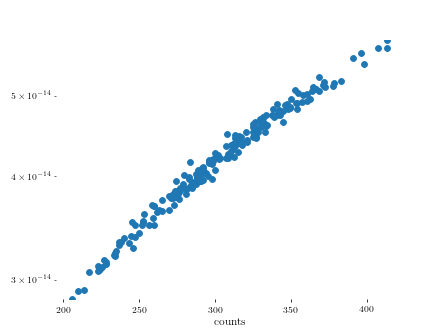

<IPython.core.display.Javascript object>


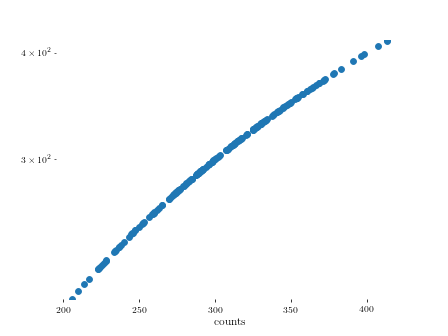

In [178]:
# plot correlations in the data
plot_correlations(extractor_fix)

# same plot, if the last bin was be equal to the number of counts
plot_correlations(extractor_fix, fake=True);

There is a good correlation, but we see some spread; something like a "noise term". There are two possible reasons for this:  
- there could be small allowed transformations between the results, such that different gsf-values for the same number of counts in a bin are allowed (again, because they lead to the same $\chi^2$)
- "noise" in the minimization: Sometimes the minimizer does not find the best solution for the last gsf bin, as we might terminate earlier than necessary/possible (all minimizers have some settings (tolerance, max_iter, ...)  on when to end)

Let us have a look at the first part, the allowed transformations. How would the plot above look like if we had different transformations $\alpha$ for the solutions:

<IPython.core.display.Javascript object>


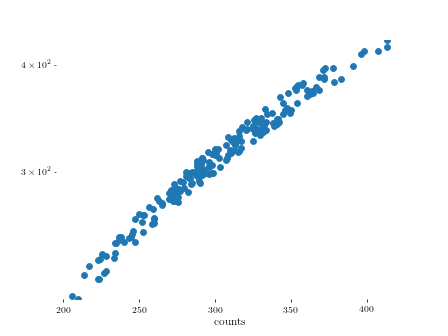

<IPython.core.display.Javascript object>


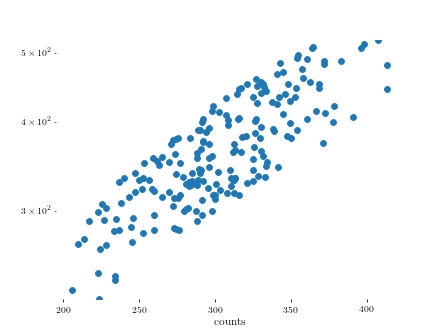

In [183]:
# if the number of counts would depend only on alpha -- how much of a spred would still be "hidden"
gsf_values_transformed = plot_correlations(extractor_fix, alpha=0.01, fake=True);

#vs something that would clearly be vissible:
gsf_values_transformed = plot_correlations(extractor_fix, alpha=0.05, fake=True);

We see here, that a transformation with a small alpha $\approx$ 0.01 would not be possible without being noticed by us

How would such a small difference in alpha look like? Can we see from the results that this is possible/impossible?

<IPython.core.display.Javascript object>


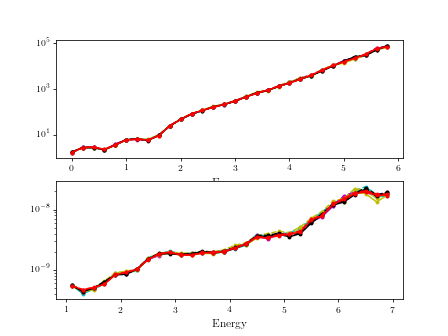

In [184]:
def plot_transformed(alpha):
    fig, ax = plt.subplots(2,1)
    colors=['c', 'm', 'y', 'k', "r"]
    for i in range(5):
        nld = extractor.nld[i].copy()
        nld.to_MeV()
        nld_plain = nld.copy() 
        nld_plain.transform(alpha=1.4)
        nld_plain.plot(ax=ax[0], color=colors[i], linestyle="-") 
        
        nld.transform(alpha=np.random.uniform(0, alpha))
        nld.transform(alpha=1.4)
        nld.plot(ax=ax[0], color=colors[i], linestyle="--", scale="log")
        
        gsf = extractor.gsf[i].copy()
        gsf.to_MeV()
        
        gsf_plain = gsf.copy()
        gsf_plain.transform(alpha=1.4)
        gsf_plain.plot(ax=ax[1], color=colors[i], linestyle="-")  
    
        gsf.transform(alpha=np.random.uniform(0, alpha))
        gsf.transform(alpha=1.4)
        gsf.plot(ax=ax[1], color=colors[i], linestyle="--", scale="log")
        
plot_transformed(alpha=0.02)

<IPython.core.display.Javascript object>


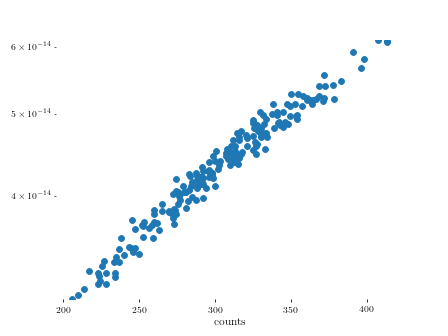

In [206]:
gsf_values_transformed = plot_correlations(extractor_fix, alpha=0.01);

<IPython.core.display.Javascript object>


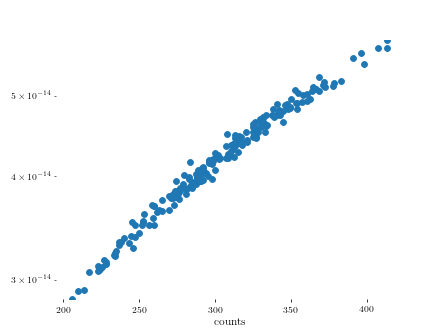

In [207]:
gsf_values_org = plot_correlations(extractor_fix);

In [216]:
def print_rel_unc(vals, bins=[10, -1]):
    rel_unc = vals.std(axis=0) / vals.mean(axis=0)
    for ibin in bins:
        print(f"bin: {ibin}, rel_unc: {rel_unc[ibin]}")
        
print("gsf_values_org: ")
print_rel_unc(gsf_values_org)

print("\ngsf_values_transformed: ")
print_rel_unc(gsf_values_transformed)

# --> The relative uncertainties change, and change differently for different regions of the gsf
# Note: it is not a large change, but either an increase of about 
# (18-21)/18 = 16%, or
# (146-148)/146 = 1.3%

gsf_values_org: 
bin: 10, rel_unc: 0.018945739291425186
bin: -1, rel_unc: 0.14693105733330533

gsf_values_transformed: 
bin: 10, rel_unc: 0.02115661989431584
bin: -1, rel_unc: 0.14893152714936217


<a id='hidden_summary'></a>

My take from this: a transformation with a small alpha is possible and we cannot detect this from a visual inspection of the plots (neither can I think of another way we might detect this). This is not a total chaos, but if it exists, it will artificially inflate the relative uncertainties at high energies vs. the relative uncertainties at low energies. If that happens, and we take these uncertainties in the normalization (for a weighted $\chi^2$ (or log-likelihood), we will get a biased result.

Let's try to summarize the differences:


| normalize mean nld & gsf                                       | normalize each nld & gsf "realization"                            |
|----------------------------------------------------------------|-------------------------------------------------------------------|
| (-) potentially biased                                         | (+) not biased                                                    |
|                                                                | (-?) influence of choice of relative unc.'s (?)                   |
| (+?) if uncertainties are correct: minimal variance            | (-?) not biased, but potentially not minimal variance             |
| (+) strict separation of counting vs normalization uncertainty | (-) no strict separation of counting vs normalization uncertainty |
| (-) limited to samplers that don't "wander" off                | (+) any sampler possible (-> more modular)                        |
|     ( ) seems to work empirically                              |     (+) theoretically more correct                                |

<a id='applying'></a>

## 3) Let's just give it a try -- what is the difference?

<a id='applying_a'></a>
### a) "real" Dy dataset

(code was in a different nb, just copying the results)

Upper pannel: normalize the ensemble mean [but the "band" is composed of the normalization unc. only]
Lower pannel: normalize each member; uncertainty afterwards (= OMpy recommendation as on 31Mar)
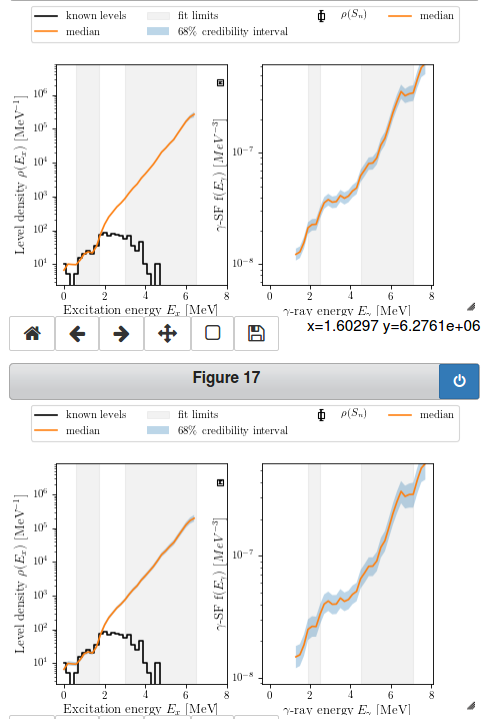

Here we see the lower variance for the *ensemble mean* result.

<a id='applying_b'></a>
### b) for the synthetic dataset
-- Here we get problems when normalizing the nld: Due to the very small uncertainty at low energies, the weighted fit is determined almost only from the low energies. In the example, it turns out that this is a problem, as alpha is determined by by the discrete region "only". 

If one want to solve this, one would either have to express the likelihood differently, or manually modify the uncertainties
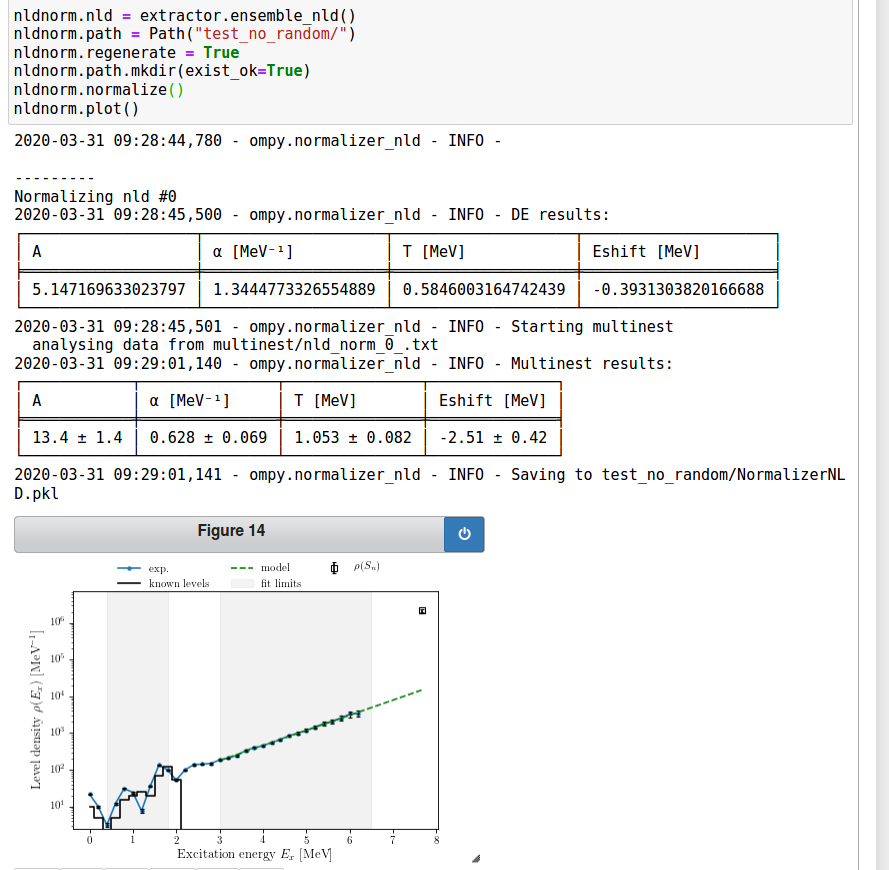

(we have seen though that the normalization works if we do it for each ensemble member as in the article, Fig4 or Fig 5 of the article:
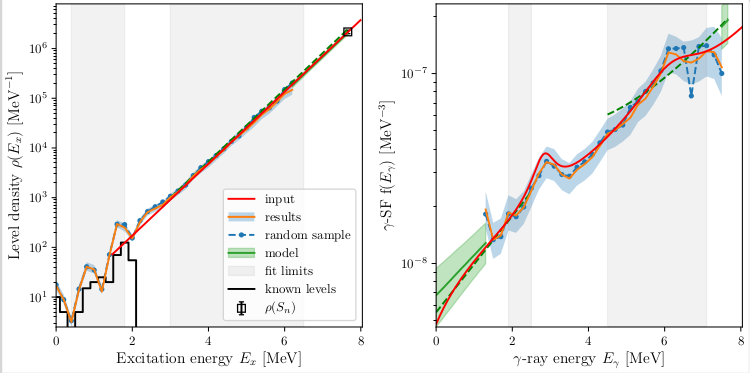

<a id='applying_summary'></a>
**My summary**: It may be that it sometimes works to normalize the mean nld and gsf. However, it is less general, and may in some cases, like for the second dataset (synthetic Dy dataset) not work. I would thus like to keep the normalization per ensemble member as a feature and general recommendation. 

**But of course, OMpy is just a library, and if one want to, one can easily decide to just normalize the ensemble means.**

Just to have the code documented to get the ensemble means:

``` py
simnorm_mean = copy.deepcopy(simnorm)
simnorm_mean.path = Path("test_no_random/")
simnorm_mean.nld = extractor.ensemble_nld()
simnorm_mean.gsf = extractor.ensemble_gsf()
simnorm_mean.regenerate = True
simnorm_mean.normalize()
```

and combine the statistical and normalization uncertainty:
``` py
simnorm_mean.plot()
ensemblenorm_sim_mean = copy.deepcopy(ensemblenorm_sim) 

# use each member (to get statistical uncertainties), but transform
# with the same normalization parameters, obtained from simnorm_mean
ensemblenorm_sim_mean.extractor.nld = extractor.nld
ensemblenorm_sim_mean.extractor.gsf = extractor.gsf

ensemblenorm_sim_mean.res = [simnorm_mean.res for i in extractor.nld]

ensemblenorm_sim_mean.plot(n_plot=0)
```